In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from pathlib import Path
from multiprocessing import Pool
from tqdm.auto import tqdm
import re

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import matplotlib.colors

import noctiluca as nl

In [2]:
def find_timestep(npy):
    tim = npy['tim']
    tid = npy['tid']

    dt = np.diff(tim)[np.diff(tid) == 0] # exclude steps across different trajectories
    if np.any(dt == 0):
        raise ValueError("Found zero time lag!")

    # Numerics might be better if everything is O(1)
    scale = np.min(dt)
    dt = dt / scale
    mindt = np.min(dt)
    
    # Step 1: rough estimate through MSE
    def mse(step):
        ints = np.round(dt/step).astype(int)
        return np.sum((dt-step*ints)**2)

    res = optimize.minimize(mse, mindt,
                            bounds=[(mindt, np.inf)],
                           )
    if not res.success:
        print(res)
        raise RuntimeError

    step = res.x

    # Step 2: identify real integer steps
    udts = []
    Ns = []
    cur = 0.5*step
    while cur < np.max(dt):
        ind = (dt > cur) & (dt < cur+step)
        Ns.append(np.sum(ind))
        if Ns[-1] > 0:
            udts.append(np.mean(dt[ind]))
            cur = udts[-1] + 0.5*step
        else:
            udts.append(np.nan)
            cur += step
    udts = np.array(udts)
    Ns   = np.array(Ns)

    # Step 3: fit actual best lag time
    ind = ~np.isnan(udts)
    with np.errstate(divide='ignore'):
        sigma = 1/np.sqrt(Ns[ind]-1)
    res = optimize.curve_fit(lambda x, a: a*x,
                             np.arange(len(udts))[ind]+1,
                             udts[ind],
                             sigma=sigma,
                            )

    return res[0][0]*scale

In [3]:
def load_file(file, relpath, dt_dict=None):
    npy = np.load(file)
    dt = find_timestep(npy)
    
    tim = npy['tim']
    tid = npy['tid']
    loc = npy['itr'][:, -1]['loc'][:, :2] # (#loc, 2) (we ignore z, since data is 2D)
    
    utid = np.unique(tid)
    
    data = nl.TaggedSet()
    for my_tid in utid:
        ind = tid == my_tid
        my_tim = tim[ind]
        my_loc = loc[ind]
        
        lag = np.round(np.diff(my_tim)/dt).astype(int)
        t = np.insert(np.cumsum(lag), 0, 0)
        
        traj = nl.Trajectory(my_loc, t=t, tid=my_tid, dt=dt)
        data.add(traj)
    
    relfile = file.relative_to(relpath)
    data.addTags(f'file={str(relfile)}')
    data.addTags(filename2tags(relfile))
    
    if dt_dict is not None:
        dt_dict[str(relfile)] = dt
    
    return data

In [4]:
def filename2tags(f):
    s = str(f)
    tags = set()

    L = re.search('L\d+', s)[0]
    tags |= {'L='+L[1:]}
    
    return tags

In [5]:
path = Path('../raw_data/MINFLUX/L-Sweep/npy')
files = []
files += list((path).rglob('*.npy'))
len(files)

88

In [6]:
dt_dict = {}
data = nl.TaggedSet()
for f in tqdm(files):
    data |= load_file(f, path, dt_dict)

  0%|          | 0/88 [00:00<?, ?it/s]

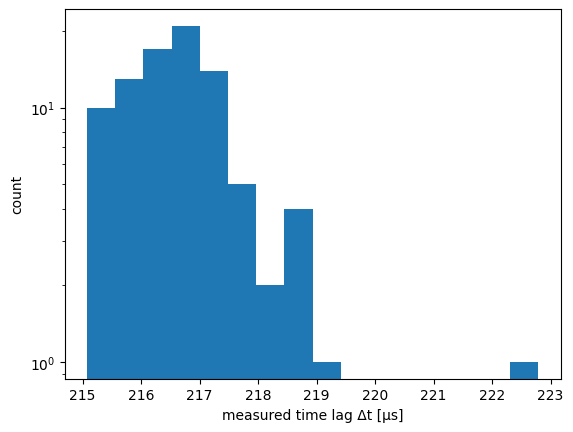

215.0773185126437 L250/240823-153109_minflux.npy
215.13243457020815 L250/240823-152724_minflux.npy
215.38620963106845 L100/240823-161802_minflux.npy
215.42089098175498 L100/240823-124002_minflux.npy
215.45295079612924 L250/240823-153327_minflux.npy
215.46143824379917 L250/240823-154225_minflux.npy
215.49894747845818 L250/240823-154934_minflux.npy
215.5002445387105 L250/240823-152847_minflux.npy
215.50843939289737 L100/240823-124345_minflux.npy
215.54490588648002 L150/240823-160751_minflux.npy
215.56701444531916 L100/240823-160957_minflux.npy
215.59793899172612 L30/240530-175757_minflux.npy
215.6547611441922 L250/240823-153652_minflux.npy
215.69367481662735 L30/240530-180408_minflux.npy
215.69992675215792 L250/240823-154708_minflux.npy
215.70921323640493 L30/240530-175702_minflux.npy
215.79647753939463 L100/240823-161401_minflux.npy
215.85910951433172 L200/240823-152223_minflux.npy
215.90474643093867 L100/240823-124939_minflux.npy
215.95376944062508 L30/240531-125220_minflux.npy
215.959

In [7]:
# Check time steps
dts = np.array([dt_dict[f] for f in dt_dict])
fs  = np.array([f          for f in dt_dict])

plt.hist(dts*1e6, bins='auto')

plt.yscale('log')
plt.xlabel('measured time lag Δt [μs]')
plt.ylabel('count')
plt.show()

ind = np.argsort(dts)
for i in ind:
    print(dts[i]*1e6, str(fs[i]))

In [8]:
# Some cleanup
data.makeSelection(lambda traj, _: traj.F < 2)
print(f"Deleting {len(data)} trajectories with < 2 localizations")
data.deleteSelection()

# Cut off first localization (bc that's the first one, where we have to search for the locus)
for traj in data:
    i_start = np.nonzero(np.cumsum(~np.isnan(traj.abs()[:][:, 0])) == 2)[0][0]
    traj.data = traj.data[:, i_start:, :]

Deleting 40 trajectories with < 2 localizations


In [9]:
tagsets = []
data.makeSelection()
Ls = sorted({int(tag[2:]) for tag in data.tagset() if tag.startswith('L=')})
for L in Ls:
    tagsets.append({f'L={L}'})
            
print('#trajs     tags')
print(50*'-')
            
N_total = 0
for tags in tagsets:
    data.makeSelection(tags, logic=all)
    taglist = []
    for ident in ['L']:
        tgs = {tag for tag in tags if tag.startswith(ident+'=')}
        if len(tgs) > 0:
            taglist.append(tgs.pop())
            
    print(f'{len(data):5d}      '+(len(taglist)*'{:20s}').format(*taglist))
    N_total += len(data)

print(50*'-')
data.makeSelection(lambda _, tags: not any(all(tag in tags for tag in tagset)
                                           for tagset in tagsets))
print(f'{len(data):5d}      '+'<none of the above; just to check>')

print(50*'-')
data.makeSelection()
print(f'{N_total:5d}      '+'sum of above')
print(f'{len(data):5d}      '+'total in data set')

#trajs     tags
--------------------------------------------------
  609      L=30                
  545      L=40                
  648      L=100               
  571      L=150               
  569      L=175               
  580      L=200               
  920      L=250               
--------------------------------------------------
    0      <none of the above; just to check>
--------------------------------------------------
 4442      sum of above
 4442      total in data set


In [10]:
def tags2label(tags, omit=set()):
    taglist = []
    for ident in ['L']:
        if ident in omit:
            continue
            
        tgs = {tag for tag in tags if tag.startswith(ident+'=')}
        if len(tgs) > 0:
            tag = tgs.pop()
            
            val = re.match(ident+'=(.*)', tag)[1]
            if ident == 'L':
                val = 'L'+val
                
            taglist.append(val)
    
    return ', '.join(taglist)

In [11]:
conditions = []
for tags in tagsets:
    data.makeSelection(tags, logic=all)
    cond = tags2label(tags)
    data.addTags({cond, 'condition='+cond})
    conditions.append(cond)

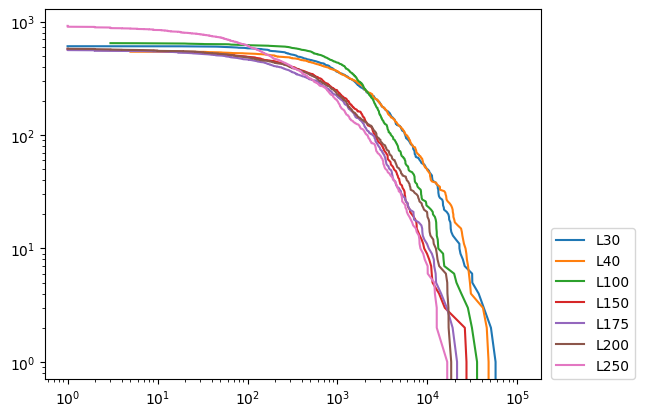

In [12]:
# Check survival curves
# --> *need* proper parallelization for MSD calculation, otherwise we're screwed hard
for cond in conditions:
    data.makeSelection(cond)
    
    lens = np.flip(np.sort(list(map(len, data))))
    Fs   = np.flip(np.sort(list(map(lambda traj : traj.F, data))))

    plt.plot(lens, np.arange(len(lens)), label=cond)
    # plt.plot(Fs, np.arange(len(Fs)))

plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(1.02, 0.0))

plt.show()

In [13]:
# Pre-compute MSDs
data.makeSelection()
with nl.Parallelize():
    _ = nl.analysis.MSD(data, chunksize=1, show_progress=True)

  0%|          | 0/4442 [00:00<?, ?it/s]

In [14]:
data.makeSelection()
nl.io.write.hdf5({
    'data'       : data,
    'conditions' : conditions,
    'tagsets'    : tagsets,
    'dt_dict'    : dt_dict,
    'description' : """
MINFLUX L-sweep

H2B (U2OS) data, raw, with different L.

Contents of this file:
 - 'data'       : the data
 - 'conditions' : list of strings identifying each of the conditions;
                  can be used as tags in 'data'
 - 'tagsets'    : list of sets of tags into 'data', corresponding to
                  'conditions'; might be useful
 - 'dt_dict'    : lag time extracted from each file. Note that trajectories
                  in 'data' also have meta-entries 'dt'. Generally seems
                  consistent at 216μs

Other notes:
 - we did not (yet) filter out short trajectories
 - the first localization of each trajectory has been removed
 - MSDs are pre-calculated for all trajectories
"""[1:-1],
}, '../data/20240825_minflux_L-sweep_raw.h5')